## Coleta de dados
- Baixamos candles diários do yfinance para `ticker` (AMZN por padrão).
- Usamos datas explícitas (start/end) e `group_by='column'` para evitar MultiIndex.
- Salvamos em Parquet para reuso sem depender da rede.


In [1]:
#está tudo ok

from datetime import datetime, timedelta, timezone
from pathlib import Path
import pandas as pd
import yfinance as yf

# --- parâmetros ---
ticker = "AMZN"
arquivo_parquet = Path("amzn_3m.parquet")


end = datetime.now(timezone.utc).date()
start = end - timedelta(days=1825)  # ~5 anos

df = yf.download(
    tickers=ticker,
    start=start.isoformat(),
    end=(end + timedelta(days=1)).isoformat(),  # 'end' exclusivo
    interval="1d",
    auto_adjust=True,     # ajusta OHLC por proventos/splits
    actions=True,         # inclui 'Dividends' e 'Stock Splits'
    group_by="column",    # <- evita MultiIndex nas colunas
    progress=False,
    threads=True,
)

if df.empty:
    raise ValueError("Nenhum dado retornado pelo yfinance para o período solicitado.")

df = df.reset_index()

if isinstance(df.columns, pd.MultiIndex):
    df.columns = [
        "_".join([str(x) for x in tup if x is not None and str(x) != ""])
        .lower()
        .replace(" ", "_")
        for tup in df.columns
    ]
else:
    df.columns = [str(c).lower().replace(" ", "_") for c in df.columns]

if "date" not in df.columns:
    for cand in ("Date", "datetime", "index"):
        if cand in df.columns:
            df = df.rename(columns={cand: "date"})
            break

df["date"] = pd.to_datetime(df["date"], utc=True).dt.tz_convert(None)
df.to_parquet(arquivo_parquet, index=False)
print(f"Salvo: {arquivo_parquet.resolve()}")

print(f"Arquivo parquet disponível: {arquivo_parquet.resolve()}")


Salvo: /home/vladm/Dev/api_lstm_acao/amzn_3m.parquet
Arquivo parquet disponível: /home/vladm/Dev/api_lstm_acao/amzn_3m.parquet


## Entendendo e preparando os dados
- Inspeção inicial (head, info, descrição) para checar tipos e valores ausentes.
- Normalizamos nomes de colunas e garantimos a coluna de data em `datetime` sem timezone.
- Mantemos apenas OHLCV e eventos (dividendos/splits) para derivar features.


## Carregamento do Parquet
Lê o arquivo salvo para um DataFrame e inspeciona as primeiras linhas.


In [2]:
import pandas as pd

caminho_arquivo = "amzn_3m.parquet"

df = pd.read_parquet(caminho_arquivo)

df.head()


,date,close_amzn,dividends_amzn,high_amzn,low_amzn,open_amzn,stock_splits_amzn,volume_amzn
0,2020-11-27,159.766998,0.0,160.809494,159.502502,160.563004,0.0,47858000
1,2020-11-30,158.401993,0.0,161.419495,156.277496,160.423996,0.0,81278000
2,2020-12-01,161.003998,0.0,162.447495,157.858994,159.425003,0.0,90740000
3,2020-12-02,160.176498,0.0,161.600006,158.662994,161.082504,0.0,62586000
4,2020-12-03,159.336502,0.0,161.432007,159.065506,160.272995,0.0,57840000


### Visão inicial do dataset
- Conferimos as primeiras linhas para validar schema (datas, OHLCV, eventos).


## Ordenação por data
Converte a coluna de data, ordena e define como índice para garantir série temporal consistente.


In [3]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')
df.head()

,close_amzn,dividends_amzn,high_amzn,low_amzn,open_amzn,stock_splits_amzn,volume_amzn
date,,,,,,,
2020-11-27,159.766998,0.0,160.809494,159.502502,160.563004,0.0,47858000
2020-11-30,158.401993,0.0,161.419495,156.277496,160.423996,0.0,81278000
2020-12-01,161.003998,0.0,162.447495,157.858994,159.425003,0.0,90740000
2020-12-02,160.176498,0.0,161.600006,158.662994,161.082504,0.0,62586000
2020-12-03,159.336502,0.0,161.432007,159.065506,160.272995,0.0,57840000


## Estatísticas básicas
Mostra início/fim da série e a frequência de intervalos de datas para checar buracos no calendário.


In [4]:
print("Primeira data:", df.index.min())
print("Última data:", df.index.max())
print("Total de registros:", len(df))
print(df.index.to_series().diff().value_counts())

Primeira data: 2020-11-27 00:00:00
Última data: 2025-11-24 00:00:00
Total de registros: 1254
date
1 days    981
3 days    224
4 days     37
2 days     11
Name: count, dtype: int64


## Seleção de colunas base
Cria o DataFrame de trabalho apenas com OHLCV da AMZN.

In [5]:
colunas_features = [f"{col}_{ticker.lower()}" for col in ("open", "high", "low", "close", "volume")]
df_model = df[colunas_features].copy()
df_model.head()


,open_amzn,high_amzn,low_amzn,close_amzn,volume_amzn
date,,,,,
2020-11-27,160.563004,160.809494,159.502502,159.766998,47858000
2020-11-30,160.423996,161.419495,156.277496,158.401993,81278000
2020-12-01,159.425003,162.447495,157.858994,161.003998,90740000
2020-12-02,161.082504,161.600006,158.662994,160.176498,62586000
2020-12-03,160.272995,161.432007,159.065506,159.336502,57840000


## Engenharia de features
Deriva retornos, médias móveis, volatilidade, faixa diária e tendência de volume antes de treinar.

In [6]:

# ► Retornos percentuais
df_model['return_1d'] = df_model['close_amzn'].pct_change()
df_model['return_5d'] = df_model['close_amzn'].pct_change(5)

# ► Médias móveis mais curtas (captura tendência recente)
df_model['ma_5']  = df_model['close_amzn'].rolling(5).mean()
df_model['ma_10'] = df_model['close_amzn'].rolling(10).mean()
df_model['ma_20'] = df_model['close_amzn'].rolling(20).mean()

# ► Volatilidade e range diário
df_model['vol_10'] = df_model['close_amzn'].pct_change().rolling(10).std()
df_model['price_range'] = (df_model['high_amzn'] - df_model['low_amzn']) / df_model['close_amzn']

# ► Tendência de volume
df_model['volume_trend'] = df_model['volume_amzn'].pct_change()

df_model = df_model.dropna()
df_model.shape


(1235, 13)

## Prévia das features
Visualiza as primeiras linhas do `df_model` após as derivações para checar consistência.


In [7]:
df_model.head()

,open_amzn,high_amzn,low_amzn,close_amzn,volume_amzn,return_1d,return_5d,ma_5,ma_10,ma_20,vol_10,price_range,volume_trend
date,,,,,,,,,,,,,
2020-12-24,159.695007,160.100006,158.449997,158.634506,29038000,-0.003949,-0.019588,159.723105,159.439302,158.912850,0.009981,0.010401,-0.306572
2020-12-28,159.699997,165.199997,158.634506,164.197998,113736000,0.035071,0.025709,160.546204,160.277002,159.134400,0.014421,0.039985,2.916799
2020-12-29,165.496994,167.532501,164.061005,166.100006,97458000,0.011584,0.036124,161.704404,161.102153,159.519301,0.014343,0.020900,-0.143121
2020-12-30,167.050003,167.104996,164.123505,164.292496,64186000,-0.010882,0.024740,162.497702,161.705803,159.683726,0.015221,0.018147,-0.341398
2020-12-31,163.750000,164.145996,162.059998,162.846497,59144000,-0.008801,0.022497,163.214301,161.785652,159.817226,0.013879,0.012810,-0.078553


## Normalizar e evitar vazamento
- Ajustamos o scaler só no trecho de treino para não vazar informação do futuro.
- Guardamos o scaler para inverter a escala na avaliação e em produção.

## Normalização (MinMax)
Ajusta o scaler somente no pedaço inicial (80%) para evitar leakage e transforma todo o conjunto.


In [8]:
from sklearn.preprocessing import MinMaxScaler

# evitar leakage: ajustar scaler só no treino (80% inicial)
train_size_raw = int(len(df_model) * 0.8)
scaler = MinMaxScaler()
scaler.fit(df_model.iloc[:train_size_raw].values)
scaled_data = scaler.transform(df_model.values)

scaled_data[:3]



array([[0.5853761 , 0.57861356, 0.59497871, 0.58069627, 0.02944291,
        0.49499105, 0.48532825, 0.60265671, 0.60985545, 0.61985006,
        0.08756616, 0.05143137, 0.0996803 ],
       [0.58541408, 0.61712732, 0.59640404, 0.62275472, 0.36686551,
        0.63644499, 0.60484576, 0.60917445, 0.61664763, 0.62174194,
        0.17709444, 0.41294608, 1.        ],
       [0.62954469, 0.63474176, 0.63832369, 0.63713337, 0.3020167 ,
        0.55130009, 0.6323271 , 0.61834569, 0.62333806, 0.62502872,
        0.1755312 , 0.17972553, 0.14533377]])

### Função para gerar sequências
- Recebe o DataFrame já normalizado e o `lookback`.
- Retorna `X` com shape `(n_amostras, lookback, n_features)` e `y` com o próximo valor normalizado.
- Descarta janelas incompletas e respeita a ordem temporal.

### Gerar sequências e verificar shapes
- Executamos a função e checamos dimensões de `X` e `y` para confirmar o pipeline (20 passos, n_features esperado).
- Opcional: visualizar um exemplo de sequência para sanity-check.




In [9]:
import numpy as np

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :])  # todas as features
        y.append(data[i, df_model.columns.get_loc("close_amzn")])  # prever close
    return np.array(X), np.array(y)

lookback = 20  # janela ajustada após busca rápida
X, y = create_sequences(scaled_data, lookback)
X.shape, y.shape

((1215, 20, 13), (1215,))

## Dividir em treino / teste preservando a ordem
- Split temporal: parte inicial para treino, final para teste (sem shuffle).
- Guarda índices ou datas para rastrear onde a divisão ocorreu.


In [10]:
tamanho_treino = int(len(X) * 0.7)
tamanho_valid  = int(len(X) * 0.15)

X_train = X[:tamanho_treino]
y_train = y[:tamanho_treino]

X_val = X[tamanho_treino:tamanho_treino + tamanho_valid]
y_val = y[tamanho_treino:tamanho_treino + tamanho_valid]

X_test  = X[tamanho_treino + tamanho_valid:]
y_test  = y[tamanho_treino + tamanho_valid:]

X_train.shape, X_val.shape, X_test.shape


((850, 20, 13), (182, 20, 13), (183, 20, 13))

## Arquitetura e compilação
Define a LSTM (96→48), aplica dropout, adiciona densas finais e compila com Adam (lr=7e-4), MSE e MAE.


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks # type: ignore
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(42)

n_features = X.shape[-1]
close_idx = df_model.columns.get_loc("close_amzn")

model = models.Sequential([
    layers.Input(shape=(lookback, n_features)),
    layers.LSTM(96, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(48),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

optimizer = Adam(learning_rate=7e-4, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
model.summary()


2025-11-24 22:55:10.266134: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-24 22:55:10.267388: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 22:55:10.424303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-24 22:55:11.898772: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 96)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,681 (280.00 KB)

 Trainable params: 71,681 (280.00 KB)

 Non-trainable params: 0 (0.00 B)

## Criação de sequências
Função auxiliar que monta janelas temporais de tamanho `lookback` para alimentar a LSTM.


In [12]:
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=4,
    min_lr=1e-5
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    shuffle=False,
    verbose=1
)



Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0702 - mae: 0.2247 - val_loss: 0.1182 - val_mae: 0.3235 - learning_rate: 7.0000e-04
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0160 - mae: 0.1029 - val_loss: 0.0703 - val_mae: 0.2417 - learning_rate: 7.0000e-04
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0056 - mae: 0.0583 - val_loss: 0.0292 - val_mae: 0.1422 - learning_rate: 7.0000e-04
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0039 - mae: 0.0482 - val_loss: 0.0240 - val_mae: 0.1255 - learning_rate: 7.0000e-04
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0036 - mae: 0.0475 - val_loss: 0.0238 - val_mae: 0.1258 - learning_rate: 7.0000e-04
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0040 - mae: 0.0499 - val_loss: 0.0260 - val_mae: 0.1332 - learning_rate: 7.0000e-04
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0049 - mae: 0.0547 - val_loss: 0.0294 - val_mae: 0.1449 - learning_ra

## Avaliação e inversão de escala
Converte previsões e alvos de volta ao preço original com o scaler, calcula RMSE/MAE em escala normalizada e em preço, e exibe os resultados.


In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def invert_scale(values):
    zeros = np.zeros((len(values), scaled_data.shape[1]))
    zeros[:, close_idx] = values
    return scaler.inverse_transform(zeros)[:, close_idx]

y_pred = model.predict(X_test).squeeze()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

y_test_price = invert_scale(y_test)
y_pred_price = invert_scale(y_pred)

print(f"RMSE (escala normalizada): {rmse:.4f}")
print(f"MAE  (escala normalizada): {mae:.4f}")
print(f"RMSE em preço: {np.sqrt(mean_squared_error(y_test_price, y_pred_price)):.4f}")
print(f"MAE  em preço: {mean_absolute_error(y_test_price, y_pred_price):.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
RMSE (escala normalizada): 0.0853
MAE  (escala normalizada): 0.0719
RMSE em preço: 11.2827
MAE  em preço: 9.5173


## Gráfico teste (preço real vs previsto)
Compara visualmente a série de teste com a previsão bruta do modelo.


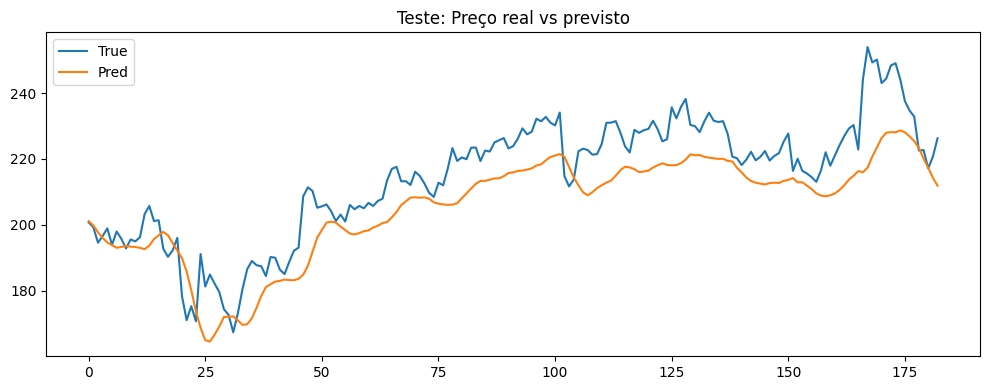

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(y_test_price, label="True")
plt.plot(y_pred_price, label="Pred")
plt.title("Teste: Preço real vs previsto")
plt.legend()
plt.tight_layout()
plt.show()


## Tabela de previsões
Cria um DataFrame com `y_true_price` e `y_pred_price` para inspeção rápida.


In [15]:
import pandas as pd

df_pred = pd.DataFrame({
    "y_true_price": y_test_price,
    "y_pred_price": y_pred_price
})

df_pred.head()


,y_true_price,y_pred_price
0,200.699997,201.108127
1,199.250000,199.776277
2,194.539993,197.715710
3,196.589996,195.965137
4,198.889999,194.622446


## Calibração linear das previsões
Ajusta uma regressão linear sobre as previsões para corrigir viés e recalcula métricas em preço.


In [16]:
from sklearn.linear_model import LinearRegression
import numpy as np

y_pred_price_train = invert_scale(model.predict(np.concatenate([X_train, X_val])).squeeze())
y_true_price_train = invert_scale(np.concatenate([y_train, y_val]))

lr = LinearRegression()
lr.fit(y_pred_price_train.reshape(-1, 1), y_true_price_train)

# aplicar calibração ao teste
y_pred_price_cal = lr.predict(y_pred_price.reshape(-1, 1))

rmse_cal = np.sqrt(mean_squared_error(y_test_price, y_pred_price_cal))
mae_cal  = mean_absolute_error(y_test_price, y_pred_price_cal)

print(f"Calibrado RMSE: {rmse_cal:.4f}")
print(f"Calibrado MAE : {mae_cal:.4f}")
print(f"Coeficiente: {lr.coef_[0]:.4f}, Intercepto: {lr.intercept_:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Calibrado RMSE: 9.0138
Calibrado MAE : 7.1549
Coeficiente: 1.0418, Intercepto: -5.4943


## Gráfico: previsão bruta vs calibrada
Plota valores verdadeiros, previsão bruta e previsão calibrada para comparação visual.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


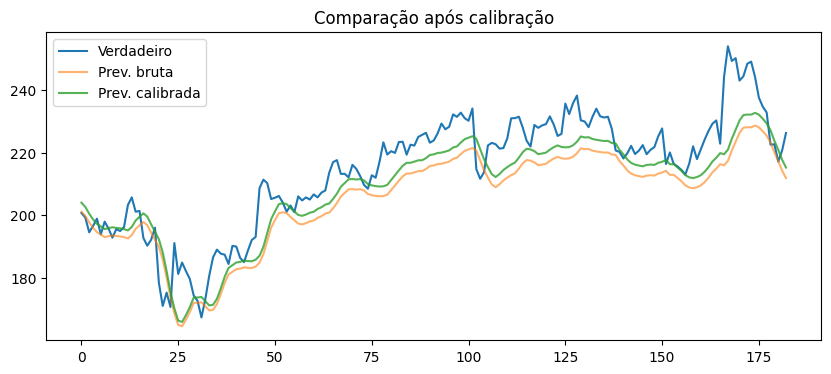

In [17]:
import matplotlib.pyplot as plt

y_pred_raw = model.predict(X_test).squeeze()
y_pred_raw_price = invert_scale(y_pred_raw)
y_pred_cal_price = lr.predict(y_pred_raw_price.reshape(-1, 1)).ravel()

plt.figure(figsize=(10,4))
plt.plot(y_test_price, label="Verdadeiro")
plt.plot(y_pred_raw_price, label="Prev. bruta", alpha=0.6)
plt.plot(y_pred_cal_price, label="Prev. calibrada", alpha=0.8)
plt.legend(); plt.title("Comparação após calibração");

## Salvamento de artefatos
Exporta modelo Keras, scaler, calibrador e metadados para a pasta `artifacts/`.


In [18]:
from pathlib import Path
import json as json_lib
import joblib

artefacts = Path("artifacts")
artefacts.mkdir(exist_ok=True)

# salvar modelo Keras
model.save(artefacts / "lstm_model.keras")  # formato nativo Keras

# salvar scaler e calibrador (regressão linear)
joblib.dump(scaler, artefacts / "scaler.pkl")
joblib.dump(lr, artefacts / "calibrator.pkl")

# salvar metadados para reproduzir o pipeline
metadata = {
    "lookback": lookback,
    "feature_order": list(df_model.columns),
    "target_column": "close_amzn",
    "close_idx": close_idx,
    # train_size_raw não é salvo (derivado do split original)
}
(artefacts / "metadata.json").write_text(json_lib.dumps(metadata, indent=2))

print("Artefatos salvos em", artefacts.resolve())


Artefatos salvos em /home/vladm/Dev/api_lstm_acao/artifacts
